
XGboost with best parameter from randomized search
- subject
- subject and category
- subject, category, hazard_type, origin
- in addition, classification, type, year, date
> 인용구 추가



In [1]:
import pandas as pd
import numpy as np
import re

from sentence_transformers import SentenceTransformer

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings("ignore")

In [2]:

# ============================================================
# 2. Load Data
# ============================================================

df = pd.read_csv("/content/rasff_new2.csv")

In [3]:
# ============================================================
# 1. Clean Text Functions
# ============================================================

def clean_text(text):
    if text is None:
        return ""
    text = str(text)

    # Replace multiple slashes with space
    text = re.sub(r'/+', ' ', text)

    # Add space between number and letters: 25g → 25 g
    text = re.sub(r'(\d)([A-Za-z])', r'\1 \2', text)

    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Clean subject + category
df["subject_clean"] = df["subject"].apply(clean_text)
df["category_clean"] = df["category"].apply(clean_text)

In [4]:
# ----------------------------
# 2. Recode risk_decision into 2 classes
# ----------------------------
def recode_risk(risk):
    if risk in ['no risk', 'not serious', 'potential risk', 'undecided', 'potentially serious']:
        return 0   # Lower to medium risk
    elif risk == 'serious':
        return 1   # High risk
    else:
        return -1  # Safety net for unexpected values

df['risk_decision_2class']=df['risk_decision'].apply(recode_risk)
print(df['risk_decision_2class'].value_counts())

risk_decision_2class
1    14756
0    12641
Name: count, dtype: int64


In [5]:
# ----------------------
# Load and prepare data
# ----------------------
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

# ----------------------
# Time-based split (80/20)
# ----------------------
cutoff_index = int(len(df) * 0.8)
cutoff_date = df.iloc[cutoff_index]['date']

train_df = df[df['date'] <= cutoff_date]
test_df  = df[df['date'] > cutoff_date]

In [6]:
from sentence_transformers import SentenceTransformer
# ----------------------
# Sentence Transformer Embedding
# ----------------------
model = SentenceTransformer('all-MiniLM-L6-v2')

train_sub_emb = model.encode(train_df['subject_clean'].tolist(), show_progress_bar=True)
test_sub_emb = model.encode(test_df['subject_clean'].tolist(), show_progress_bar=True)

train_cat_emb = model.encode(train_df['category_clean'].tolist(), show_progress_bar=True)
test_cat_emb = model.encode(test_df['category_clean'].tolist(), show_progress_bar=True)

#Convert embeddings to DataFrame
sub_cols = [f"sub_emb_{i}" for i in range(train_sub_emb.shape[1])]
cat_cols = [f"cat_emb_{i}" for i in range(train_cat_emb.shape[1])]

train_sub_df = pd.DataFrame(train_sub_emb, columns=sub_cols, index=train_df.index)
test_sub_df = pd.DataFrame(test_sub_emb, columns=sub_cols, index=test_df.index)

train_cat_df = pd.DataFrame(train_cat_emb, columns=cat_cols, index=train_df.index)
test_cat_df = pd.DataFrame(test_cat_emb, columns=cat_cols, index=test_df.index)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/685 [00:00<?, ?it/s]

Batches:   0%|          | 0/172 [00:00<?, ?it/s]

Batches:   0%|          | 0/685 [00:00<?, ?it/s]

Batches:   0%|          | 0/172 [00:00<?, ?it/s]

In [7]:
#Hazard type one-hot
hazard_ohe = pd.get_dummies(df["Hazard_Type"], prefix="hazard")
train_hazard = hazard_ohe.loc[train_df.index]
test_hazard = hazard_ohe.loc[test_df.index]

In [8]:
#classification one-hot
notification = pd.get_dummies(df["classification"], prefix="notification")
train_not = notification.loc[train_df.index]
test_not = notification.loc[test_df.index]

In [20]:
#type one-hot
type_ohe = pd.get_dummies(df["type"], prefix="notification")
train_type = type_ohe.loc[train_df.index]
test_type = type_ohe.loc[test_df.index]

In [9]:
#Origin multi-hot
df["origin"] = df["origin"].fillna("")
df["origin_list"] = df["origin"].str.split(r"[,/]+")

all_origins = sorted(set([o.strip() for sublist in df["origin_list"] for o in sublist if o.strip()]))

for o in all_origins:
  df[f"origin_{o}"] = df["origin_list"].apply(lambda x: 1 if o in [i.strip() for i in x] else 0)

origin_cols = [f"origin_{o}" for o in all_origins]
train_origin = df.loc[train_df.index, origin_cols]
test_origin = df.loc[test_df.index, origin_cols]

In [10]:
# Optional: check distribution
print(train_df['risk_decision_2class'].value_counts())
print(test_df['risk_decision_2class'].value_counts())


# Update target variable
target_col = 'risk_decision_2class'

risk_decision_2class
1    12204
0     9714
Name: count, dtype: int64
risk_decision_2class
0    2927
1    2552
Name: count, dtype: int64


In [12]:
#including subject, category, hazard type, origin
X_train = pd.concat([train_sub_df, train_cat_df, train_hazard, train_origin], axis=1)
X_test = pd.concat([test_sub_df, test_cat_df, test_hazard, test_origin], axis=1)

y_train = train_df['risk_decision_2class']
y_test = test_df['risk_decision_2class']

In [13]:
print("X_train shape:", X_train.shape)
print("X_test shape: ", X_test.shape)
print("y_train distribution:\n", y_train.value_counts())
print("y_test distribution:\n", y_test.value_counts())

X_train shape: (21918, 943)
X_test shape:  (5479, 943)
y_train distribution:
 risk_decision_2class
1    12204
0     9714
Name: count, dtype: int64
y_test distribution:
 risk_decision_2class
0    2927
1    2552
Name: count, dtype: int64


In [16]:
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score

### best parameter on subject
xgb=xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    learning_rate=0.03,
    max_depth=10,
    subsample=1.0,
    colsample_bytree=0.6,
    n_estimators=1000,
    min_child_weight= 10,
    gamma = 0.2,
    tree_method='hist',
    random_state=42,
    use_label_encoder=False
)

xgb.fit(
    X_train, y_train
)

y_pred = xgb.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.7539697025004563
              precision    recall  f1-score   support

           0       0.82      0.69      0.75      2927
           1       0.70      0.83      0.76      2552

    accuracy                           0.75      5479
   macro avg       0.76      0.76      0.75      5479
weighted avg       0.76      0.75      0.75      5479



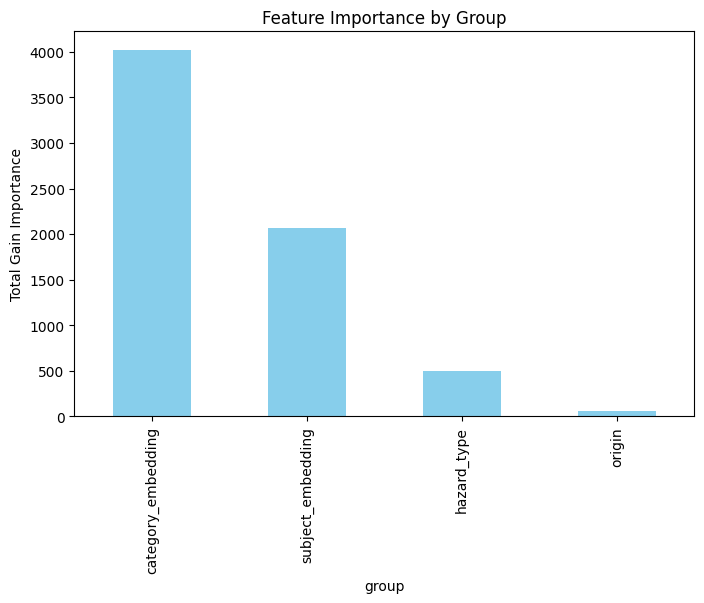

group
category_embedding    4021.663363
subject_embedding     2068.887552
hazard_type            496.835533
origin                  61.059614
Name: importance, dtype: float64


In [22]:
import matplotlib.pyplot as plt
import pandas as pd

#Get raw feature importance

importance = xgb.get_booster().get_score(importance_type='gain')
importance_df = pd.DataFrame({
'feature': list(importance.keys()),
'importance': list(importance.values())
})


#Define groups

def map_feature_group(col):
  if col.startswith('sub_emb_'):
      return 'subject_embedding'
  elif col.startswith('cat_emb_'):
      return 'category_embedding'
  elif col.startswith('hazard_'):
      return 'hazard_type'
  elif col.startswith('origin_'):
      return 'origin'
  else:
      return 'other'

importance_df['group'] = importance_df['feature'].apply(map_feature_group)

#Sum importance per group

grouped_importance = importance_df.groupby('group')['importance'].sum().sort_values(ascending=False)

plt.figure(figsize=(8, 5))
grouped_importance.plot(kind='bar', color='skyblue')
plt.ylabel('Total Gain Importance')
plt.title('Feature Importance by Group')
plt.show()

print(grouped_importance)

In [23]:
#removing origin column
X_train = pd.concat([train_sub_df, train_cat_df, train_hazard], axis=1)
X_test = pd.concat([test_sub_df, test_cat_df, test_hazard], axis=1)

y_train = train_df['risk_decision_2class']
y_test = test_df['risk_decision_2class']

In [24]:
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score

### best parameter on subject
xgb=xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    learning_rate=0.03,
    max_depth=10,
    subsample=1.0,
    colsample_bytree=0.6,
    n_estimators=1000,
    min_child_weight= 10,
    gamma = 0.2,
    tree_method='hist',
    random_state=42,
    use_label_encoder=False
)

xgb.fit(
    X_train, y_train
)

y_pred = xgb.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.7578025187077934
              precision    recall  f1-score   support

           0       0.82      0.70      0.75      2927
           1       0.70      0.83      0.76      2552

    accuracy                           0.76      5479
   macro avg       0.76      0.76      0.76      5479
weighted avg       0.77      0.76      0.76      5479



In [25]:
#removing origin and hazard type column
X_train = pd.concat([train_sub_df, train_cat_df], axis=1)
X_test = pd.concat([test_sub_df, test_cat_df], axis=1)

y_train = train_df['risk_decision_2class']
y_test = test_df['risk_decision_2class']

In [26]:
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score

### best parameter on subject
xgb=xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    learning_rate=0.03,
    max_depth=10,
    subsample=1.0,
    colsample_bytree=0.6,
    n_estimators=1000,
    min_child_weight= 10,
    gamma = 0.2,
    tree_method='hist',
    random_state=42,
    use_label_encoder=False
)

xgb.fit(
    X_train, y_train
)

y_pred = xgb.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.7505019164081037
              precision    recall  f1-score   support

           0       0.82      0.69      0.75      2927
           1       0.70      0.82      0.75      2552

    accuracy                           0.75      5479
   macro avg       0.76      0.76      0.75      5479
weighted avg       0.76      0.75      0.75      5479



In [27]:
#only subject
X_train = pd.concat([train_sub_df], axis=1)
X_test = pd.concat([test_sub_df], axis=1)

y_train = train_df['risk_decision_2class']
y_test = test_df['risk_decision_2class']

In [28]:
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score

### best parameter on subject
xgb=xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    learning_rate=0.03,
    max_depth=10,
    subsample=1.0,
    colsample_bytree=0.6,
    n_estimators=1000,
    min_child_weight= 10,
    gamma = 0.2,
    tree_method='hist',
    random_state=42,
    use_label_encoder=False
)

xgb.fit(
    X_train, y_train
)

y_pred = xgb.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.7521445519255339
              precision    recall  f1-score   support

           0       0.81      0.70      0.75      2927
           1       0.70      0.81      0.75      2552

    accuracy                           0.75      5479
   macro avg       0.76      0.76      0.75      5479
weighted avg       0.76      0.75      0.75      5479



**Undersample class i inside training set to make it balanced dataset**

In [42]:
from sklearn.utils import resample

# Separate majority and minority classes
train_majority = train_df[train_df[target_col] == 1]
train_minority = train_df[train_df[target_col] == 0]

# Undersample majority to match minority size
train_majority_downsampled = resample(
    train_majority,
    replace=False,
    n_samples=len(train_minority),
    random_state=42
)

# Combine back into a balanced dataframe
train_df_balanced = pd.concat([train_minority, train_majority_downsampled]).sample(frac=1, random_state=42)

print(train_df_balanced[target_col].value_counts())

risk_decision_2class
0    9714
1    9714
Name: count, dtype: int64


In [44]:
balanced_train_idx = train_df_balanced.index

X_train = pd.concat([
    train_sub_df.loc[balanced_train_idx],
    train_cat_df.loc[balanced_train_idx],
    train_hazard.loc[balanced_train_idx],
    train_origin.loc[balanced_train_idx]
], axis=1)

y_train = train_df_balanced[target_col]


X_test = pd.concat([test_sub_df, test_cat_df], axis=1)
y_test = test_df['risk_decision_2class']

In [46]:
# Align train and test columns
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

In [47]:
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score

### best parameter on subject
xgb=xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    learning_rate=0.03,
    max_depth=10,
    subsample=1.0,
    colsample_bytree=0.6,
    n_estimators=1000,
    min_child_weight= 10,
    gamma = 0.2,
    tree_method='hist',
    random_state=42,
    use_label_encoder=False
)

xgb.fit(
    X_train, y_train
)

y_pred = xgb.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.7532396422704873
              precision    recall  f1-score   support

           0       0.79      0.73      0.76      2927
           1       0.71      0.78      0.75      2552

    accuracy                           0.75      5479
   macro avg       0.75      0.76      0.75      5479
weighted avg       0.76      0.75      0.75      5479



**add classification **

In [11]:
#including subject, category, hazard type, origin adding classification
X_train = pd.concat([train_sub_df, train_cat_df, train_hazard, train_origin, train_not], axis=1)
X_test = pd.concat([test_sub_df, test_cat_df, test_hazard, test_origin, test_not], axis=1)

y_train = train_df['risk_decision_2class']
y_test = test_df['risk_decision_2class']



In [ ]:
print("X_train shape:", X_train.shape)
print("X_test shape: ", X_test.shape)
print("y_train distribution:\n", y_train.value_counts())
print("y_test distribution:\n", y_test.value_counts())

In [12]:
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score

### best parameter on subject
xgb=xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    learning_rate=0.03,
    max_depth=10,
    subsample=1.0,
    colsample_bytree=0.6,
    n_estimators=1000,
    min_child_weight= 10,
    gamma = 0.2,
    tree_method='hist',
    random_state=42,
    use_label_encoder=False
)

xgb.fit(
    X_train, y_train
)

y_pred = xgb.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8256981200949078
              precision    recall  f1-score   support

           0       0.90      0.76      0.82      2927
           1       0.76      0.90      0.83      2552

    accuracy                           0.83      5479
   macro avg       0.83      0.83      0.83      5479
weighted avg       0.84      0.83      0.83      5479



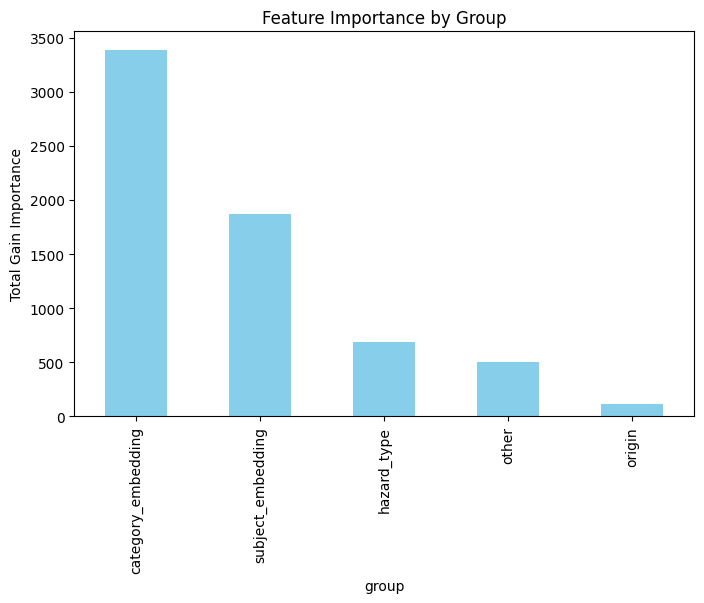

group
category_embedding    3388.140682
subject_embedding     1868.170140
hazard_type            691.531878
other                  501.054733
origin                 110.876180
Name: importance, dtype: float64


In [13]:
import matplotlib.pyplot as plt
import pandas as pd

#Get raw feature importance

importance = xgb.get_booster().get_score(importance_type='gain')
importance_df = pd.DataFrame({
'feature': list(importance.keys()),
'importance': list(importance.values())
})


#Define groups

def map_feature_group(col):
  if col.startswith('sub_emb_'):
      return 'subject_embedding'
  elif col.startswith('cat_emb_'):
      return 'category_embedding'
  elif col.startswith('hazard_'):
      return 'hazard_type'
  elif col.startswith('origin_'):
      return 'origin'
  else:
      return 'other'

importance_df['group'] = importance_df['feature'].apply(map_feature_group)

#Sum importance per group

grouped_importance = importance_df.groupby('group')['importance'].sum().sort_values(ascending=False)

plt.figure(figsize=(8, 5))
grouped_importance.plot(kind='bar', color='skyblue')
plt.ylabel('Total Gain Importance')
plt.title('Feature Importance by Group')
plt.show()

print(grouped_importance)

In [14]:
#including subject, category, hazard type, adding classification
X_train = pd.concat([train_sub_df, train_cat_df, train_hazard, train_not], axis=1)
X_test = pd.concat([test_sub_df, test_cat_df, test_hazard, test_not], axis=1)

y_train = train_df['risk_decision_2class']
y_test = test_df['risk_decision_2class']


In [15]:
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score

### best parameter on subject
xgb=xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    learning_rate=0.03,
    max_depth=10,
    subsample=1.0,
    colsample_bytree=0.6,
    n_estimators=1000,
    min_child_weight= 10,
    gamma = 0.2,
    tree_method='hist',
    random_state=42,
    use_label_encoder=False
)

xgb.fit(
    X_train, y_train
)

y_pred = xgb.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8244205146924621
              precision    recall  f1-score   support

           0       0.90      0.76      0.82      2927
           1       0.76      0.90      0.83      2552

    accuracy                           0.82      5479
   macro avg       0.83      0.83      0.82      5479
weighted avg       0.84      0.82      0.82      5479



In [16]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Fit on TRAIN only
train_scaled = scaler.fit_transform(train_df[['year', 'month']])
test_scaled = scaler.transform(test_df[['year', 'month']])

# Convert back to DataFrame
train_time = pd.DataFrame(train_scaled,
                          columns=['year_scaled', 'month_scaled'],
                          index=train_df.index)

test_time = pd.DataFrame(test_scaled,
                         columns=['year_scaled', 'month_scaled'],
                         index=test_df.index)

In [17]:
X_train = pd.concat([train_sub_df,
                     train_cat_df,
                     train_hazard,
                     train_not,
                     train_time], axis=1)

X_test  = pd.concat([test_sub_df,
                     test_cat_df,
                     test_hazard,
                     test_not,
                     test_time], axis=1)

y_train = train_df['risk_decision_2class']
y_test  = test_df['risk_decision_2class']

In [18]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(21918, 784) (21918,)
(5479, 784) (5479,)


In [19]:
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score

### best parameter on subject
xgb=xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    learning_rate=0.03,
    max_depth=10,
    subsample=1.0,
    colsample_bytree=0.6,
    n_estimators=1000,
    min_child_weight= 10,
    gamma = 0.2,
    tree_method='hist',
    random_state=42,
    use_label_encoder=False
)

xgb.fit(
    X_train, y_train
)

y_pred = xgb.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8309910567621829
              precision    recall  f1-score   support

           0       0.89      0.78      0.83      2927
           1       0.78      0.89      0.83      2552

    accuracy                           0.83      5479
   macro avg       0.83      0.83      0.83      5479
weighted avg       0.84      0.83      0.83      5479



In [21]:
#including subject, category, hazard type, origin adding classification and type
X_train = pd.concat([train_sub_df, train_cat_df, train_hazard, train_origin, train_not, train_type], axis=1)
X_test = pd.concat([test_sub_df, test_cat_df, test_hazard, test_origin, test_not, test_type], axis=1)

y_train = train_df['risk_decision_2class']
y_test = test_df['risk_decision_2class']

In [22]:
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score

### best parameter on subject
xgb=xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    learning_rate=0.03,
    max_depth=10,
    subsample=1.0,
    colsample_bytree=0.6,
    n_estimators=1000,
    min_child_weight= 10,
    gamma = 0.2,
    tree_method='hist',
    random_state=42,
    use_label_encoder=False
)

xgb.fit(
    X_train, y_train
)

y_pred = xgb.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8258806351524001
              precision    recall  f1-score   support

           0       0.90      0.76      0.82      2927
           1       0.77      0.90      0.83      2552

    accuracy                           0.83      5479
   macro avg       0.83      0.83      0.83      5479
weighted avg       0.84      0.83      0.83      5479

